In [31]:
import pybullet_envs
import numpy as np
import torch
import torch.nn as nn
import os
import pickle
import xarray as xr
import matplotlib.pyplot as plt
import copy
import pybullet_envs
import panda_gym
import collections

from seagul.rl.ars.ars_zoo import ARSZooAgent
from seagul.mesh import mdim_div_stable, mesh_dim, mesh_find_target_d, dict_to_array, DualRewardDiv, mdim_safe_stable_nolen, cdim_safe_stable_nolen
from seagul.zoo3_utils import do_rollout_stable, load_zoo_agent

torch.set_default_dtype(torch.float32)


%matplotlib inline
%load_ext autoreload
%autoreload 2

#env_name = 'HalfCheetahBulletEnv-v0'
#algo = 'ppo'

algo = 'tqc'

# env_name = 'FetchPickAndPlace-v1'
# env, model = load_zoo_agent(env_name, algo, render=False)


env_name = "PandaPickAndPlace-v1"
env, model = load_zoo_agent(env_name, algo, render=False, env_kwargs={"render":False})

# env_name = "HalfCheetahBulletEnv-v0"
# env, model = load_zoo_agent(env_name, algo, render=False, env_kwargs={"render":False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1


In [32]:
o,a,r,i = do_rollout_stable(env, model, render=False);

# if type(o[0]) == collections.OrderedDict:
#     o,ach,des = dict_to_array(o)



# plt.plot(o);
# plt.figure()

# plt.plot(ach);
# plt.plot(des);

print(sum(r))
print(sum(fn(o, a, r)))

[-4.]
[-5.417806]


In [20]:
#mdim, cdim, m,d = mesh_dim(o[200:], upper_size_ratio=1.0, lower_size_ratio=0.0)
#dcrit = mesh_find_target_d(o)

# plt.loglog(d,m,'x-')
# plt.xlabel('d')
# plt.ylabel('m')

# print(mdim)
# print(cdim)
# print(dcrit)

In [3]:
from seagul.mesh import cdim_div_panda
old_model = model
new_agent = ARSZooAgent(env_name, algo, seed=0, n_workers=24, n_delta=72, postprocessor=cdim_div_panda, step_schedule=[0.05, 0.005],  exp_schedule=[0.05, 0.005])

/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1

/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndP

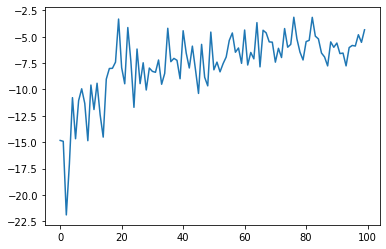

In [4]:
new_agent.learn(100);
plt.plot(new_agent.raw_rew_hist)

In [5]:
env, old_model = load_zoo_agent(env_name, algo)

model_list = [old_model, new_agent.model]
num_runs = 10

for model in model_list:
    mdims = xr.DataArray(np.zeros((num_runs)))
    cdims = xr.DataArray(np.zeros((num_runs)))
    rews =  xr.DataArray(np.zeros((num_runs)))

    for j in range(num_runs):
        odict,a,r,l = do_rollout_stable(env, model)
        
        o_list = []
        ach_list = []
        des_list = []
        for thing in odict:
            o_list.append(thing['observation'])
            ach_list.append(thing['achieved_goal'])
            des_list.append(thing['desired_goal'])
    
        o = np.stack(o_list).squeeze()
        ach = np.stack(ach_list).squeeze()
        des = np.stack(des_list).squeeze()

        
        o_norm = o
        #o_norm  = o_norm[200:]
        rews[j] = np.sum(r)
        try:
            mdims[j], cdims[j], _, _ = mesh_dim(o_norm)
        except:
            mdims[j] = np.nan
            cdims[j] = np.nan
    print("mesh dimension")
    print(mdims.data)
    mean = mdims.mean().item()
    std = mdims.std().item()
    print(f"mean: {mean}, std: {std}")
    
    print("c dimension")
    print(cdims.data)
    mean = cdims.mean().item()
    std = cdims.std().item()
    print(f"mean: {mean}, std: {std}")

    print("rewards")
    print(rews.data)
    mean = rews.mean().item()
    std = rews.std().item()
    print(f"mean: {mean}, std: {std}")
    print();print()

/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1
mesh dimension
[0.73830625 0.55601747 0.57961004 0.53950235 1.12596163 0.64767337
 0.47338692 0.55734345 0.77326188 0.67465979]
mean: 0.6665723150789564, std: 0.17696685404128262
c dimension
[2.22390109 2.22390109 3.80178402 2.22390109 3.15576586 2.47905476
 2.22390109 2.57788293 2.47905476 2.57788293]
mean: 2.596702961035012, std: 0.4846738301071566
rewards
[ -4.  -6.  -8.  -7.  -7.  -7.  -6. -10.   0.  -8.]
mean: -6.3, std: 2.570992026436488


mesh dimension
[1.41049042 1.19762635 1.47063601 0.92487988 0.41067994 1.26827046
 1.1965108  0.9523487  1.05347646 1.08695825]
mean: 1.0971877276078021, std: 0.28474920181865016
c dimension
[3.3953155  4.44780217 5.47674585 4.44780217 2.22390109 6.0256851
 2.22390109 3.80178402 2.42337088 3.80178402]
mean: 3.8268091891724794, std: 1.2499727204110054
rewards
[ -5.  -6.  -7. -10. -10.  -7. -10.  -9.  -9.  -8.]
mean: -8.1, std: 1.7




In [2]:
from ray import tune

def training_function(config):
    import pybullet_envs

    train, env_name, algo = config["train"], config["env_name"], config["algo"]
    env, model = load_zoo_agent(env_name, algo)
    
    if train:
        new_agent = ARSZooAgent(env_name, algo, n_workers=24, n_delta=64, postprocessor=mdim_div_stable, step_schedule=[0.05, 0.005],  exp_schedule=[0.05, 0.005])
        new_agent.learn(100) 
    
    o,a,r,l = do_rollout_stable(env, model)
    o_norm = env.normalize_obs(o).squeeze()
    o_norm  = o_norm[200:]
    rew = np.sum(r)
    
    try:
        mdim, _, _, _ = mesh_dim(o_norm)
    except:
        mdim = np.nan

    tune.report(mdim=mdim, reward=rew)


analysis = tune.run(
    training_function,
    config={
        "train" : tune.grid_search([False, True]),
        "env_name": tune.grid_search(["Walker2DBulletEnv-v0","HalfCheetahBulletEnv-v0","HopperBulletEnv-v0"]),
        "algo": tune.grid_search(['ppo', 'a2c'])
    })

print("Best config: ", analysis.get_best_config(
    metric="mdim", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

2021-08-29 02:20:20,584	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-29 02:20:22,149	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-08-29 02:20:22,174	WARNING tune.py:494 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc,algo,env_name,train
training_function_55f9f_00000,RUNNING,,ppo,Walker2DBulletEnv-v0,False
training_function_55f9f_00001,PENDING,,a2c,Walker2DBulletEnv-v0,False
training_function_55f9f_00002,PENDING,,ppo,HalfCheetahBulletEnv-v0,False
training_function_55f9f_00003,PENDING,,a2c,HalfCheetahBulletEnv-v0,False
training_function_55f9f_00004,PENDING,,ppo,HopperBulletEnv-v0,False
training_function_55f9f_00005,PENDING,,a2c,HopperBulletEnv-v0,False
training_function_55f9f_00006,PENDING,,ppo,Walker2DBulletEnv-v0,True
training_function_55f9f_00007,PENDING,,a2c,Walker2DBulletEnv-v0,True
training_function_55f9f_00008,PENDING,,ppo,HalfCheetahBulletEnv-v0,True
training_function_55f9f_00009,PENDING,,a2c,HalfCheetahBulletEnv-v0,True


(pid=13558) 2021-08-29 02:20:22,693	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=13558) Traceback (most recent call last):
(pid=13558)   File "/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=13558)     self._entrypoint()
(pid=13558)   File "/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=13558)     self._status_reporter.get_checkpoint())
(pid=13558)   File "/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ray/tune/function_runner.py", line 580, in _trainable_func
(pid=13558)     output = fn()
(pid=13558)   File "<ipython-input-2-761a5f48f0d3>", line 7, in training_function
(pid=13558) NameError: name 'load_zoo_agent' is not defined
(pid=13558) Exception in thread Thread-2:
(pid=13558) Traceback (most recent call last):
(pid=13558)   File "/home/sgillen/anaconda3/envs/baselines/lib/python3.6/threading.p

Result for training_function_55f9f_00000:
  {}
  
Result for training_function_55f9f_00008:
  {}
  
Result for training_function_55f9f_00004:
  {}
  
Result for training_function_55f9f_00006:
  {}
  
Result for training_function_55f9f_00002:
  {}
  
Result for training_function_55f9f_00005:
  {}
  
Result for training_function_55f9f_00007:
  {}
  
Result for training_function_55f9f_00001:
  {}
  
Result for training_function_55f9f_00010:
  {}
  
Result for training_function_55f9f_00011:
  {}
  
Result for training_function_55f9f_00003:
  {}
  
Result for training_function_55f9f_00009:
  {}
  


Trial name,status,loc,algo,env_name,train
training_function_55f9f_00000,ERROR,,ppo,Walker2DBulletEnv-v0,False
training_function_55f9f_00001,ERROR,,a2c,Walker2DBulletEnv-v0,False
training_function_55f9f_00002,ERROR,,ppo,HalfCheetahBulletEnv-v0,False
training_function_55f9f_00003,ERROR,,a2c,HalfCheetahBulletEnv-v0,False
training_function_55f9f_00004,ERROR,,ppo,HopperBulletEnv-v0,False
training_function_55f9f_00005,ERROR,,a2c,HopperBulletEnv-v0,False
training_function_55f9f_00006,ERROR,,ppo,Walker2DBulletEnv-v0,True
training_function_55f9f_00007,ERROR,,a2c,Walker2DBulletEnv-v0,True
training_function_55f9f_00008,ERROR,,ppo,HalfCheetahBulletEnv-v0,True
training_function_55f9f_00009,ERROR,,a2c,HalfCheetahBulletEnv-v0,True


TuneError: ('Trials did not complete', [training_function_55f9f_00000, training_function_55f9f_00001, training_function_55f9f_00002, training_function_55f9f_00003, training_function_55f9f_00004, training_function_55f9f_00005, training_function_55f9f_00006, training_function_55f9f_00007, training_function_55f9f_00008, training_function_55f9f_00009, training_function_55f9f_00010, training_function_55f9f_00011])

In [14]:
import pandas as pd

rd = analysis.results_df.to_csv('test.csv')

'trial_id,mdim,reward,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.train,config.env_name,config.algo\n5f944_00000,1.662833423343824,33.140342712402344,1.1313729286193848,True,,,1,efd44a352c0e4c329aa167aeb426124a,2021-08-29_01-52-02,1630227122,1.1313729286193848,3989,sguc2,128.111.57.96,1.1313729286193848,0,1,"0_algo=ppo,env_name=Walker2DBulletEnv-v0,train=False",False,Walker2DBulletEnv-v0,ppo\n5f944_00001,,3.2583043575286865,0.13784122467041016,True,,,1,f626496cbc8844ec83297e7b39a95d1b,2021-08-29_01-52-01,1630227121,0.13784122467041016,3986,sguc2,128.111.57.96,0.13784122467041016,0,1,"1_algo=a2c,env_name=Walker2DBulletEnv-v0,train=False",False,Walker2DBulletEnv-v0,a2c\n5f944_00002,1.651652224696957,27.297752380371094,1.145392894744873,True,,,1,c68871ecf92c4a8d926fef7de6a7d408,2021-08-29_01-52-02,1630227122,1.

NameError: name 'df' is not defined